In [1]:
import torch
from torch.utils.data import Dataset
from torchvision import datasets
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt
from torch import nn
training_data = datasets.FashionMNIST(
    root='data',
    train=True,
    download=True,
    transform=ToTensor()
)

test_data = datasets.FashionMNIST(
    root='data',
    train=False,
    download=True,
    transform=ToTensor()
)

  0%|          | 0/26421880 [00:00<?, ?it/s]

Extracting data/FashionMNIST/raw/train-images-idx3-ubyte.gz to data/FashionMNIST/raw



  0%|          | 0/29515 [00:00<?, ?it/s]

Extracting data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to data/FashionMNIST/raw



  0%|          | 0/4422102 [00:00<?, ?it/s]

Extracting data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to data/FashionMNIST/raw



  0%|          | 0/5148 [00:00<?, ?it/s]

Extracting data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to data/FashionMNIST/raw



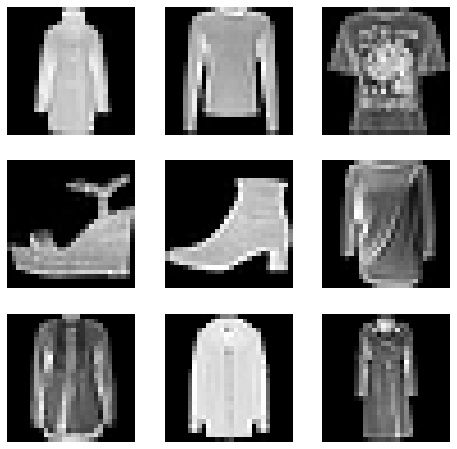

In [2]:
figure = plt.figure(figsize=(8, 8))
cols, rows = 3, 3
for i in range(1, cols * rows + 1):
  sample_idx = torch.randint(len(training_data), size = (1,)).item()
  img, label = training_data[sample_idx]
  figure.add_subplot(rows, cols, i)
  plt.axis("off")
  plt.imshow(img.squeeze(), cmap="gray")
plt.show()

In [3]:
print(training_data[3][0].shape)
print(training_data[3][1])

torch.Size([1, 28, 28])
3


In [4]:
class CustomDataset(Dataset):
  def __init__(self):
    self.x_data = [[73, 80, 75], [93,88,93], [89,91,90], [96,98,100],[73,66,70]]
    self.y_data  [[152],[185],[180],[196],[142]]

    def __len__(self):
      return len(self.x_data)

    def __getitem__(self, idx):
      x = torch.FloatTensor(self.x_data[idx])
      y = torch.FloatTensor(self.y_data[idx])
      return x,y

In [5]:
import torch
from torchvision import datasets
from torchvision.transforms import ToTensor, Lambda

ds = datasets.FashionMNIST(
    root="data",
    train=True,
    download=True,
    transform=ToTensor(),
    target_transform=Lambda(lambda y:torch.zeros(10, dtype=torch.float).scatter_(0,
    torch.tensor(y), value=1))    
)
print(ds[0][0].shape)
print(ds[0][1])

torch.Size([1, 28, 28])
tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 1.])


In [6]:
torchvision_transform = transforms.Compose([
    transforms.Resize((300,300)),
    transforms.RandomCrop(224),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2),
    transforms.RandomHorizontalFlip(p=1),
    transforms.ToTensor(),
])

torchvision_dataset = CustomDataset(
    path = 'image/',
    transform = torchvision_transform
)

NameError: ignored

In [6]:
from torch.utils.data import DataLoader

train_dataloader = DataLoader(training_data, batch_size = 64, shuffle=True)
test_dataloader = DataLoader(test_data, batch_size=64, shuffle=True)


Feature batch shape: torch.Size([64, 1, 28, 28])
Labels batch shape: torch.Size([64])


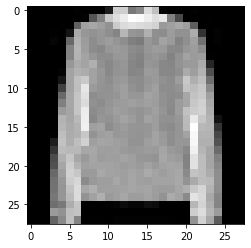

Label: 4


In [7]:
train_features, train_labels = next(iter(train_dataloader))
print(f"Feature batch shape: {train_features.size()}")
print(f"Labels batch shape: {train_labels.size()}")
img = train_features[0].squeeze()
label = train_labels[0]
plt.imshow(img, cmap="gray")
plt.show()
print(f"Label: { label}")

In [8]:
import torch
import torch.nn as nn
import torch.nn.functional as F
class MLP(torch.nn.Module):
  def __init__(self):
    super(MLP, self).__init__()
    self.linear_relu_stack = nn.Sequential(
        nn.Flatten(),
        nn.Linear(28*28, 512),
        # nn.BatchNorm1d(512),
        nn.ReLU(),
        nn.Linear(512, 512),
        # nn.BatchNorm1d(512),
        nn.ReLU(),
        nn.Linear(512, 10),
    )
  def forward(self, x):
    logits = self.linear_relu_stack(x)
    return logits

In [9]:
device = "cuda" if torch.cuda.is_available() else 'cpu'
lr = 0.001
epochs=20
model = MLP().to(device)
criterion = torch.nn.CrossEntropyLoss().to(device)
optimizer = torch.optim.SGD(model.parameters(), lr=lr)

In [10]:
for epoch in range(epochs):
  for batch_idx, (X_train, y_train) in enumerate(train_dataloader):
    model.train()
    optimizer.zero_grad()
    X_train = X_train.to(device)
    y_train = y_train.to(device)
    pred = model(X_train)
    loss = criterion(pred, y_train)
    loss.backward()
    optimizer.step()

    if(batch_idx %100==0):
     loss, current = loss.item(), batch_idx * len(X_train)
     print(f"loss: {loss:7f} [{current:5d}/{len(train_dataloader.dataset):>5d}]")
  test_loss, correct = 0,0
  model.eval()
  with torch.no_grad():
    for X_test, y_test in test_dataloader:
      X_test = X_test.to(device)
      y_test = y_test.to(device)
      pred = model(X_test)
      test_loss += criterion(pred, y_test).item()
      correct += (pred.argmax(1) == y_test).type(torch.float).sum().item()
    test_loss /= len(test_dataloader.dataset)
    correct /= len(test_dataloader.dataset)
    print(f"Test Error:\n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")

loss: 2.305442 [    0/60000]
loss: 2.291928 [ 6400/60000]
loss: 2.280941 [12800/60000]
loss: 2.262012 [19200/60000]
loss: 2.240242 [25600/60000]
loss: 2.237960 [32000/60000]
loss: 2.210499 [38400/60000]
loss: 2.200382 [44800/60000]
loss: 2.180181 [51200/60000]
loss: 2.150523 [57600/60000]
Test Error:
 Accuracy: 44.2%, Avg loss: 0.033854 

loss: 2.174080 [    0/60000]
loss: 2.138342 [ 6400/60000]
loss: 2.106728 [12800/60000]
loss: 2.082397 [19200/60000]
loss: 2.071436 [25600/60000]
loss: 1.989263 [32000/60000]
loss: 1.988124 [38400/60000]
loss: 1.950050 [44800/60000]
loss: 1.921467 [51200/60000]
loss: 1.926196 [57600/60000]
Test Error:
 Accuracy: 59.3%, Avg loss: 0.029539 

loss: 1.895854 [    0/60000]
loss: 1.827144 [ 6400/60000]
loss: 1.789581 [12800/60000]
loss: 1.724654 [19200/60000]
loss: 1.718379 [25600/60000]
loss: 1.707056 [32000/60000]
loss: 1.587765 [38400/60000]
loss: 1.584037 [44800/60000]
loss: 1.777766 [51200/60000]
loss: 1.472863 [57600/60000]
Test Error:
 Accuracy: 60.5%